In [19]:
# !pip3 install shapely
# !pip3 install plotly

# !pip3 install --upgrade google-cloud
# !pip3 install --upgrade google-cloud-bigquery
# !pip3 install --upgrade google-cloud-storage



# !gcloud auth application-default login


In [20]:
# !gcloud auth application-default login

## RUN BELOW COMMANDS IN BASE ENVIRONMENT AND THEN ACTIVATE VIRTUAL ENVIRONMENT...


# !gcloud auth application-default login --impersonate-service-account <your_service_account_id>

# !set GOOGLE_APPLICATION_CREDENTIALS=D:<your_credentials_file_path>

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from shapely import wkt
import plotly.express as px

from google.cloud import bigquery

from sklearn.preprocessing import StandardScaler

In [22]:
dataset_id = "chicago_taxi_trips"
project = "bigquery-public-data"
table_id = "taxi_trips"

# Create a "Client" object
client = bigquery.Client()

# Construct a reference to the dataset
dataset_ref = client.dataset(dataset_id=dataset_id,
                             project=project)

# Construct a reference to the table
table_ref = dataset_ref.table(table_id=table_id)

# Fetch the table
table = client.get_table(table_ref)

# Preview the first five lines of the "full" table
df = client.list_rows(table, max_results=5).to_dataframe()
df

unique_key  \
0  ca2943325bb86524ccb494a82c4361e2e59d94b9   
1  65772aeff3599d099f040068b9b7cd4491aea5b6   
2  be9aee48bd3bc2e919ad76956c94e0bc420366f1   
3  e1a250fcf325056fd51fe87e655f2ee15acd4599   
4  40c021586099a8bb48795aebbb601384304eb60e   

                                             taxi_id  \
0  4ab868a2a19b95f50f355eb8d0d7638f1912b37f49ebd6...   
1  6682944f2b37609761181033253037c05fed4377e8b649...   
2  af5b394cb22984f667fc0a9cc30e0277cb9edf50f14747...   
3  4de82fc17cb23f745931085fbbb3b4f920550cda576979...   
4  486a31c847d3de20267c610f8de52bdd13c696a8a22bcb...   

       trip_start_timestamp        trip_end_timestamp  trip_seconds  \
0 2013-04-14 14:45:00+00:00 2013-04-14 15:00:00+00:00           660   
1 2013-05-12 20:15:00+00:00 2013-05-12 20:30:00+00:00           240   
2 2013-04-17 01:45:00+00:00 2013-04-17 02:00:00+00:00           780   
3 2013-04-14 14:30:00+00:00 2013-04-14 14:45:00+00:00           360   
4 2013-04-21 02:15:00+00:00 2013-04-21 02:15:00+00:00           360   

   trip_miles  pickup_census_tract  dropoff_census_tract  \
0         0.0                 <NA>                  <NA>   
1         0.9                 <NA>                  <NA>   
2         0.0          17031841900           17031241400   
3         1.2          17031070102           17031832000   
4         0.0          17031070101           17031071200   

   pickup_community_area  dropoff_community_area  ...  extras  trip_total  \
0                     14                      14  ...     0.0        6.85   
1                     41                      41  ...     1.0        6.05   
2                     28                      24  ...     1.5       12.95   
3                      7                       6  ...     0.0        6.05   
4                      7                       7  ...     2.0        7.25   

   payment_type                            company  pickup_latitude  \
0          Cash  Blue Ribbon Taxi Association Inc.        41.968069   
1          Cash           Northwest Management LLC        41.794090   
2          Cash          Dispatch Taxi Affiliation        41.867902   
3          Cash          Dispatch Taxi Affiliation        41.930579   
4          Cash          Dispatch Taxi Affiliation        41.929263   

  pickup_longitude                       pickup_location  dropoff_latitude  \
0       -87.721559      POINT (-87.7215590627 41.968069)         41.968069   
1       -87.592311    POINT (-87.592310855 41.794090253)         41.794090   
2       -87.642959  POINT (-87.6429586652 41.8679024175)         41.906026   
3       -87.642206  POINT (-87.6422063127 41.9305785697)         41.946295   
4       -87.635891  POINT (-87.6358909539 41.9292629902)         41.921855   

   dropoff_longitude                      dropoff_location  
0         -87.721559      POINT (-87.7215590627 41.968069)  
1         -87.592311    POINT (-87.592310855 41.794090253)  
2         -87.675312   POINT (-87.6753116216 41.906025969)  
3         -87.654298  POINT (-87.6542980837 41.9462945357)  
4         -87.646211  POINT (-87.6462109769 41.9218549112)  

[5 rows x 23 columns]

### Observations counts.

In [23]:
df.columns

Index(['unique_key', 'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp',
       'trip_seconds', 'trip_miles', 'pickup_census_tract',
       'dropoff_census_tract', 'pickup_community_area',
       'dropoff_community_area', 'fare', 'tips', 'tolls', 'extras',
       'trip_total', 'payment_type', 'company', 'pickup_latitude',
       'pickup_longitude', 'pickup_location', 'dropoff_latitude',
       'dropoff_longitude', 'dropoff_location'],
      dtype='object')

In [24]:
Total_count = """
SELECT 
    COUNT(*) as Total_rows
       
       
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`;
"""

# Execute the query
query_job = client.query(Total_count)

# Convert the results to dataframe
Total_count = query_job.to_dataframe()

Total_count

Total_rows
0   214211054

In [25]:

Missing_values = """
SELECT 

    ((COUNT(*) - COUNT(unique_key))/count(*))*100 AS unique_key,
    ((COUNT(*) - COUNT(taxi_id))/count(*))*100 AS taxi_id,
    ((COUNT(*) - COUNT(trip_start_timestamp))/count(*))*100 AS trip_start_timestamp,
    ((COUNT(*) - COUNT(trip_end_timestamp))/count(*))*100 AS trip_end_timestamp,
    ((COUNT(*) - COUNT(trip_seconds))/count(*))*100 AS trip_seconds,
    ((COUNT(*) - COUNT(trip_miles))/count(*))*100 AS trip_miles,
    ((COUNT(*) - COUNT(pickup_census_tract))/count(*))*100 AS pickup_census_tract,
    ((COUNT(*) - COUNT(dropoff_census_tract))/count(*))*100 AS dropoff_census_tract,
    ((COUNT(*) - COUNT(pickup_community_area))/count(*))*100 AS pickup_community_area,
    ((COUNT(*) - COUNT(dropoff_community_area))/count(*))*100 AS dropoff_community_area,
    ((COUNT(*) - COUNT(fare))/count(*))*100 AS fare,
    ((COUNT(*) - COUNT(tips))/count(*))*100 AS tips,
    ((COUNT(*) - COUNT(tolls))/count(*))*100 AS tolls,
    ((COUNT(*) - COUNT(extras))/count(*))*100 AS extras,
    ((COUNT(*) - COUNT(trip_total))/count(*))*100 AS trip_total,
    ((COUNT(*) - COUNT(payment_type))/count(*))*100 AS payment_type,
    ((COUNT(*) - COUNT(company))/count(*))*100 AS company,
    ((COUNT(*) - COUNT(pickup_latitude))/count(*))*100 AS pickup_latitude,
    ((COUNT(*) - COUNT(pickup_longitude))/count(*))*100 AS pickup_longitude,
    ((COUNT(*) - COUNT(pickup_location))/count(*))*100 AS pickup_location,
    ((COUNT(*) - COUNT(dropoff_latitude))/count(*))*100 AS dropoff_latitude,
    ((COUNT(*) - COUNT(dropoff_longitude))/count(*))*100 AS dropoff_longitude,
    ((COUNT(*) - COUNT(dropoff_location))/count(*))*100 AS dropoff_location       
       
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`;
"""

# Execute the query
query_output = client.query(Missing_values)

# Convert the results to dataframe
Missing_value_percent = query_output.to_dataframe()
Missing_value_percent = round(Missing_value_percent.transpose(),2)
Missing_value_percent.columns = [ 'Percentage of missing values']
Missing_value_percent



Percentage of missing values
unique_key                                      0.00
taxi_id                                         0.00
trip_start_timestamp                            0.00
trip_end_timestamp                              0.01
trip_seconds                                    0.61
trip_miles                                      0.00
pickup_census_tract                            37.06
dropoff_census_tract                           37.52
pickup_community_area                          11.32
dropoff_community_area                         13.47
fare                                            0.01
tips                                            0.01
tolls                                          15.37
extras                                          0.01
trip_total                                      0.01
payment_type                                    0.00
company                                        15.68
pickup_latitude                                11.31
pickup_longitude                               11.31
pickup_location                                11.31
dropoff_latitude                               13.21
dropoff_longitude                              13.21
dropoff_location                               13.21

## Data Completeness Overview

**Key Columns with No Missing Values:** 
Important columns for basic trip and financial information (e.g., `unique_key`, `taxi_id`, `trip timestamps`, `fare`, `tips`, `payment_type`, etc.) are complete, ensuring core trip data is reliable.

**Spatial Data:** 
Pickup and dropoff latitude and longitude have moderate missing values, which could affect spatial analyses but are manageable with appropriate handling techniques.

**Census and Community Data:** 
There are high missing values in census tracts and moderate missing values in community areas. This could impact demographic and neighborhood-level analyses, necessitating more sophisticated imputation or adjustments.

**Toll Data:** 
The missing toll data suggests that either some trips did not incur tolls or the toll data was not consistently recorded.

**Company Information:** 
Missing company data indicates potential challenges in company-specific analyses but may not significantly affect general trip or fare analyses.


# Descriptive stats using BigQuery

In [26]:
col_1="""
SELECT 
    COUNT(trip_seconds) as count_,
    AVG(trip_seconds) as average_,
    MIN(trip_seconds) as min_,
    MAX(trip_seconds) as max_,
    (MAX(trip_seconds) - MIN(trip_seconds)) as range_,
    STDDEV(trip_seconds) as stddev_

FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`; 
"""
trip_seconds = client.query(col_1)
trip_seconds = trip_seconds.to_dataframe()

col_2="""
SELECT 
    COUNT(trip_miles) as count_,
    AVG(trip_miles) as average_,
    MIN(trip_miles) as min_,
    MAX(trip_miles) as max_,
    (MAX(trip_miles) - MIN(trip_miles)) as range_,
    STDDEV(trip_miles) as stddev_
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`; 
"""
col_2 = client.query(col_2)
trip_miles = col_2.to_dataframe()


col_3="""
SELECT 
    COUNT(pickup_census_tract) as count_,
    AVG(pickup_census_tract) as average_,
    MIN(pickup_census_tract) as min_,
    MAX(pickup_census_tract) as max_,
    (MAX(pickup_census_tract) - MIN(pickup_census_tract)) as range_,
    STDDEV(pickup_census_tract) as stddev_
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`; 
"""
col_3 = client.query(col_3)
pickup_census_tract = col_3.to_dataframe()



col_4="""
SELECT 
    COUNT(dropoff_census_tract) as count_,
    AVG(dropoff_census_tract) as average_,
    MIN(dropoff_census_tract) as min_,
    MAX(dropoff_census_tract) as max_,
    (MAX(dropoff_census_tract) - MIN(dropoff_census_tract)) as range_,
    STDDEV(dropoff_census_tract) as stddev_
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`; 
"""
col_4 = client.query(col_4)
dropoff_census_tract = col_4.to_dataframe()

col_5="""
SELECT 
    COUNT(pickup_community_area) as count_,
    AVG(pickup_community_area) as average_,
    MIN(pickup_community_area) as min_,
    MAX(pickup_community_area) as max_,
    (MAX(pickup_community_area) - MIN(pickup_community_area)) as range_,
    STDDEV(pickup_community_area) as stddev_

FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`; 
"""
col_5 = client.query(col_5)
pickup_community_area = col_5.to_dataframe()



col_6="""
SELECT 
    COUNT(dropoff_community_area) as count_,
    AVG(dropoff_community_area) as average_,
    MIN(dropoff_community_area) as min_,
    MAX(dropoff_community_area) as max_,
    (MAX(dropoff_community_area) - MIN(dropoff_community_area)) as range_,
    STDDEV(dropoff_community_area) as stddev_

FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`; 
"""
col_6 = client.query(col_6)
dropoff_community_area = col_6.to_dataframe()


col_7="""
SELECT 
    COUNT(fare) as count_,
    AVG(fare) as average_,
    MIN(fare) as min_,
    MAX(fare) as max_,
    (MAX(fare) - MIN(fare)) as range_,
    STDDEV(fare) as stddev_

FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`; 
"""
col_7 = client.query(col_7)
fare = col_7.to_dataframe()



col_8="""
SELECT 
    COUNT(tips) as count_,
    AVG(tips) as average_,
    MIN(tips) as min_,
    MAX(tips) as max_,
    (MAX(tips) - MIN(tips)) as range_,
    STDDEV(tips) as stddev_

FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`; 
"""
col_8 = client.query(col_8)
tips = col_8.to_dataframe()


col_9="""
SELECT 
    COUNT(tolls) as count_,
    AVG(tolls) as average_,
    MIN(tolls) as min_,
    MAX(tolls) as max_,
    (MAX(tolls) - MIN(tolls)) as range_,
    STDDEV(tolls) as stddev_

FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`; 
"""
col_9 = client.query(col_9)
tolls = col_9.to_dataframe()


col_10="""
SELECT 
    COUNT(extras) as count_,
    AVG(extras) as average_,
    MIN(extras) as min_,
    MAX(extras) as max_,
    (MAX(extras) - MIN(extras)) as range_,
    STDDEV(extras) as stddev_

FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`; 
"""
col_10 = client.query(col_10)
extras = col_10.to_dataframe()


col_11="""
SELECT 
    COUNT(trip_total) as count_,
    AVG(trip_total) as average_,
    MIN(trip_total) as min_,
    MAX(trip_total) as max_,
    (MAX(trip_total) - MIN(trip_total)) as range_,
    STDDEV(trip_total) as stddev_

FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`; 
"""
col_11 = client.query(col_11)
trip_total = col_11.to_dataframe()




df = pd.concat([trip_seconds, trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total], ignore_index=True)
df = df.rename(index={0: 'trip_seconds', 1: 'trip_miles',2:'pickup_census_tract',3:'dropoff_census_tract',4:'pickup_community_area',5:'dropoff_community_area',6:'fare',7:'tips',8:'tolls',9:'extras',10:'trip_total'})
df

count_      average_           min_           max_  \
trip_seconds            212908035  8.240717e+02            0.0        86400.0   
trip_miles              214208147  3.522398e+00            0.0         3460.0   
pickup_census_tract     134828066  1.703138e+10  17031010100.0  17031990000.0   
dropoff_census_tract    133828808  1.703136e+10  17031010100.0  17031990000.0   
pickup_community_area   189963688  2.458895e+01            1.0           77.0   
dropoff_community_area  185358912  2.220757e+01            1.0           77.0   
fare                    214182531  1.391174e+01            0.0        9999.99   
tips                    214182531  1.507456e+00            0.0         999.99   
tolls                   181294727  9.193214e-03            0.0        8099.94   
extras                  214182531  1.072829e+00            0.0        9993.41   
trip_total              214182531  1.655624e+01            0.0        9999.99   

                          range_        stddev_  
trip_seconds             86400.0    1286.014853  
trip_miles                3460.0      11.051380  
pickup_census_tract     979900.0  345749.930175  
dropoff_census_tract    979900.0  335034.432614  
pickup_community_area       76.0      20.769606  
dropoff_community_area      76.0      18.324787  
fare                     9999.99      45.370893  
tips                      999.99       2.844914  
tolls                    8099.94       3.159114  
extras                   9993.41      20.671961  
trip_total               9999.99      51.073997

## Relationship between trip distance and fare Amount

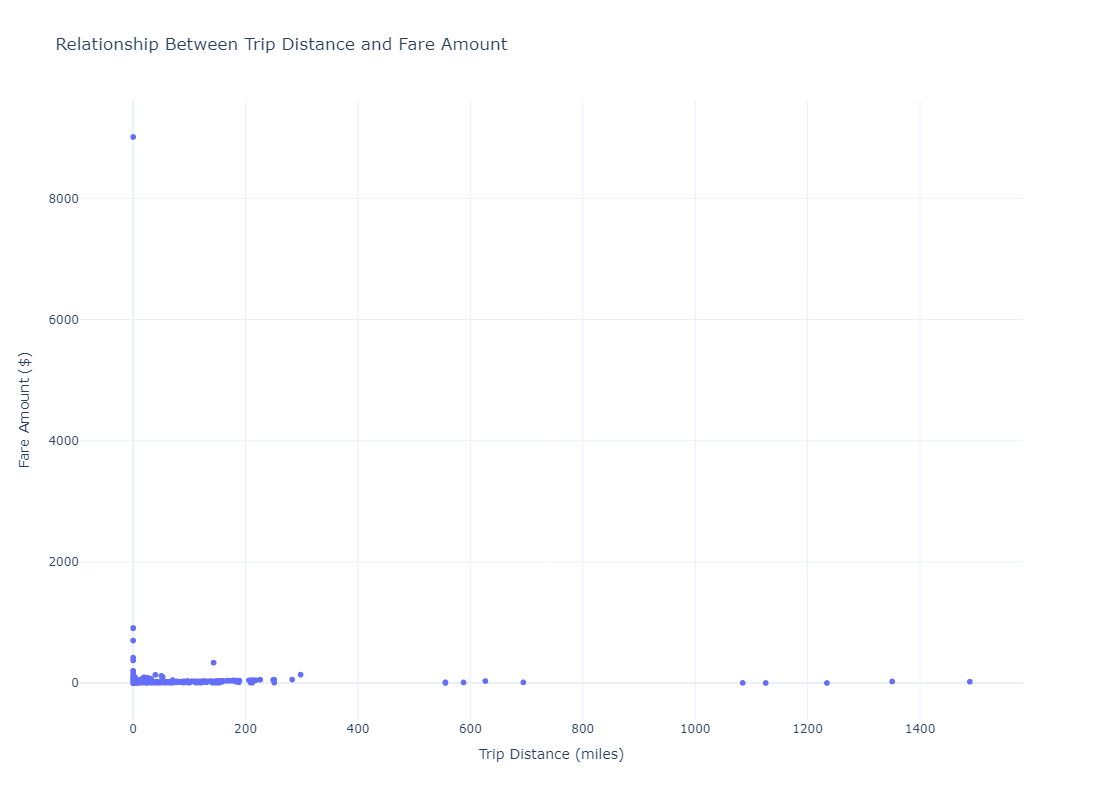

In [27]:
client = bigquery.Client()

# Query to extract trip distance and fare amount
query = """
SELECT trip_miles AS trip_distance, fare
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE fare IS NOT NULL AND trip_miles IS NOT NULL
LIMIT 100000;
"""

# Run the query and convert to DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Plotting
fig = px.scatter(df, x='trip_distance', y='fare',
                 title='Relationship Between Trip Distance and Fare Amount',
                 labels={'trip_distance': 'Trip Distance (miles)', 'fare': 'Fare Amount ($)'},
                 template='plotly_white')
fig.update_layout(autosize=False, width=1100, height=800)
fig.show()

### Insights Derived from the Analysis
The visualization generated through this EDA reveals a general trend where the fare amount tends to increase with the trip distance. However, the presence of significant variability and outliers, especially for longer trips, suggests that additional factors may influence fare calculation. These findings highlight the complexity of fare determination and the need to consider a broader array of variables in any predictive modeling.

### Implications for Modeling and Business Objectives
Drawing from the insights of this EDA, it becomes evident that an effective fare prediction model should incorporate not only distance but potentially other influential factors such as time of day, traffic conditions, and special pricing agreements. This broader approach aligns closely with business goals aiming at developing a dynamic and accurate fare pricing model that reflects real-world operations and enhances competitive positioning


.

## Average Fare Amount by Hour of Day

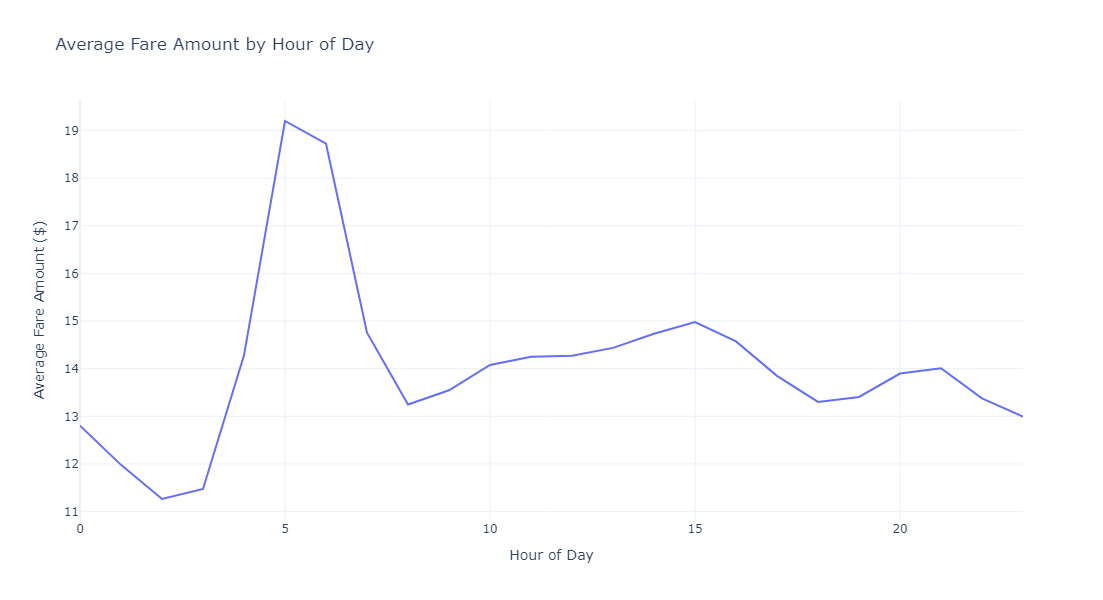

In [28]:
from google.cloud import bigquery
import pandas as pd
import plotly.express as px

client = bigquery.Client()

# Query to extract hour of day and average fare amount
query = """
SELECT EXTRACT(HOUR FROM trip_start_timestamp) AS hour_of_day, AVG(fare) AS avg_fare
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE fare IS NOT NULL
GROUP BY hour_of_day
ORDER BY hour_of_day;
"""

# Run the query and convert to DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Plotting
fig = px.line(df, x='hour_of_day', y='avg_fare',
              title='Average Fare Amount by Hour of Day',
              labels={'hour_of_day': 'Hour of Day', 'avg_fare': 'Average Fare Amount ($)'},
              template='plotly_white')
fig.update_layout(autosize=True, width=1100, height=600)
fig.show()

### Insights Derived from the Analysis
The line graph indicates a significant peak in average fare during the early morning hours, specifically around 5 AM, followed by a general decline with slight increases during the late afternoon and evening hours. This peak may reflect higher demand or fewer available taxis during early morning commutes, suggesting that fares could be dynamically adjusted based on time-based demand.


### Implications for Modeling and Business Objectives
The insights from this temporal analysis of fares suggest that any predictive fare model should include time of day as a critical factor. Incorporating time-based variability can enhance the accuracy of fare predictions and align them more closely with observed demand patterns. For business strategies, this analysis supports the implementation of dynamic pricing models that adjust fares based on time-specific demand, potentially maximizing revenue and improving customer satisfaction by offering competitive fares during off-peak hours.

## Average Fare Amount by Day of Week

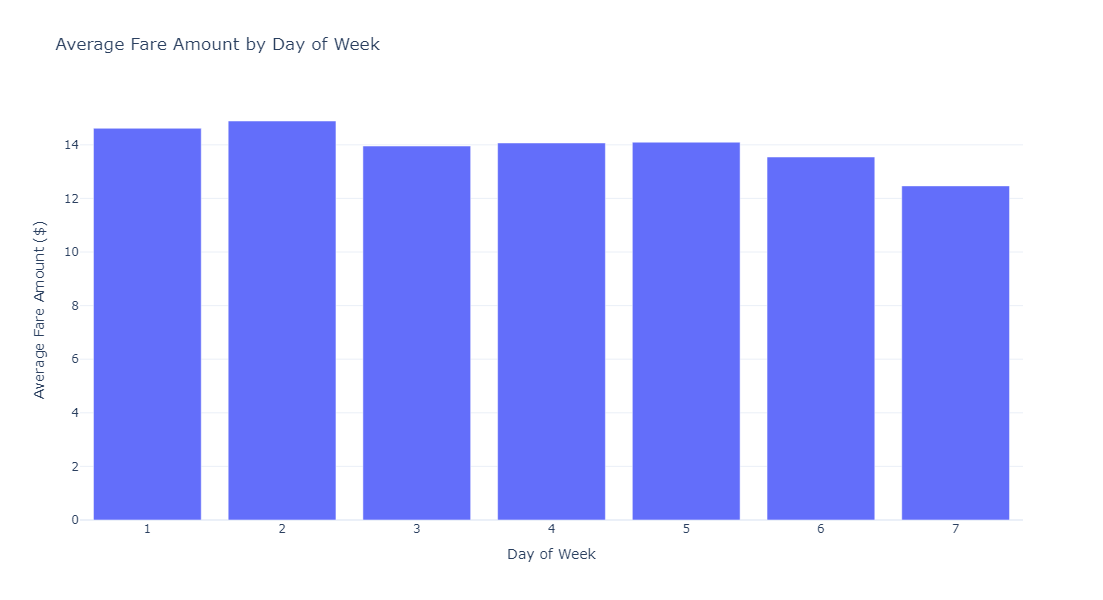

In [29]:
from google.cloud import bigquery
import pandas as pd
import plotly.express as px

client = bigquery.Client()

# Query to extract day of week and average fare amount
query = """
SELECT EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS day_of_week, AVG(fare) AS avg_fare
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE fare IS NOT NULL
GROUP BY day_of_week
ORDER BY day_of_week;
"""

# Run the query and convert to DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Plotting
fig = px.bar(df, x='day_of_week', y='avg_fare',
             title='Average Fare Amount by Day of Week',
             labels={'day_of_week': 'Day of Week', 'avg_fare': 'Average Fare Amount ($)'},
             template='plotly_white')
fig.update_layout(autosize=True, width=1100, height=600) 
fig.show()

### Insights Derived from the Analysis
The bar chart displays a relatively uniform distribution of average fare amounts across the days of the week, with slight variations. This indicates that while there may be minor fluctuations in average fares, the day of the week does not dramatically influence the fare amount, suggesting a consistent demand or pricing strategy across the week.

### Implications for Modeling and Business Objectives
Given the minor variations observed, the model for predicting fares may not need to heavily weight the day of the week as a primary predictor, unless combined with other variables such as time of day or specific events. For business strategies, this insight could justify maintaining a consistent fare structure throughout the week or exploring targeted promotions on days with marginally lower average fares to boost demand


.

## Geospatial Distribution of Taxi Pickups in Chicago

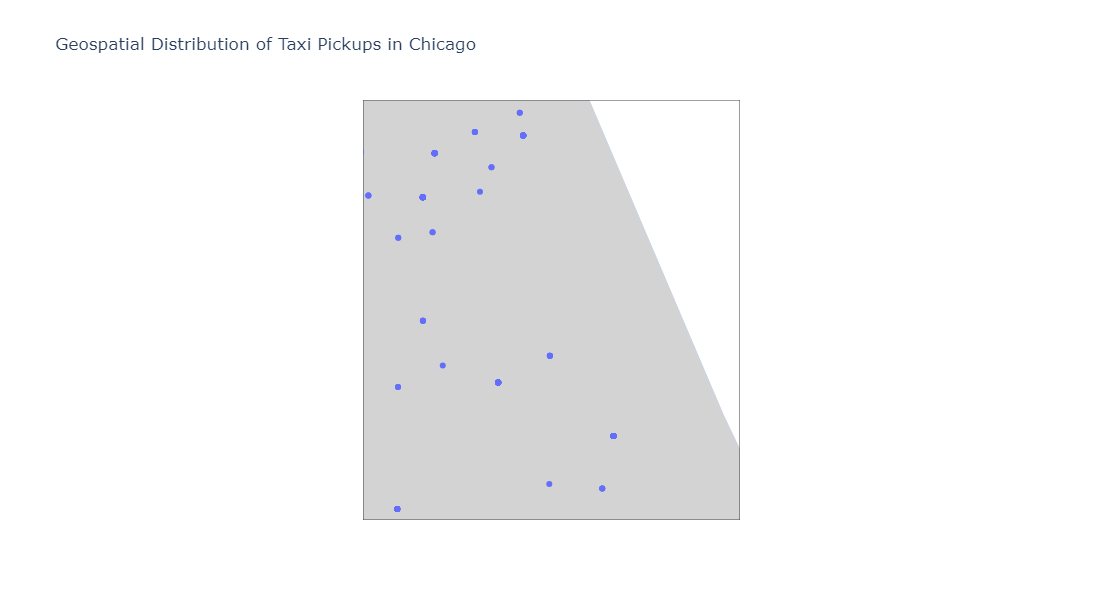

In [30]:
from google.cloud import bigquery
import pandas as pd
import plotly.express as px

client = bigquery.Client()

# Query to extract pickup locations
query = """
SELECT pickup_latitude, pickup_longitude
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL
LIMIT 1000;
"""

# Run the query and convert to DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Plotting using scatter_geo
fig = px.scatter_geo(df, lat='pickup_latitude', lon='pickup_longitude',
                     title='Geospatial Distribution of Taxi Pickups in Chicago',
                     template='plotly_white',
                     scope='north america')  # North America as the broader scope

# Fine-tuning the geo options for a closer view
fig.update_geos(
    resolution=50,  # Higher resolution for better map detail
    showcountries=True, showcoastlines=True, showland=True, landcolor='lightgrey',
    lonaxis_range=[-88.2, -87.5],  # Slightly expanded range for more room to pan
    lataxis_range=[41.6, 42.2]  # Expanded latitude range
)

fig.update_layout(
    geo=dict(
        projection_scale=10,  # Adjust scale for zooming closer to Chicago
        center=dict(lat=41.8781, lon=-87.6298)  # Ensures that Chicago remains at the center
    ),
    autosize=True, width=1100, height=600)


fig.show()

### Insights Derived from the Analysis
The scatter plot reveals distinct clusters of taxi pickups, primarily concentrated in downtown Chicago and other specific neighborhoods. This distribution likely correlates with business districts, major transport hubs, and areas with high commercial activity, indicating where the demand for taxi services is most significant.

### Implications for Modeling and Business Objectives
From the insights gained, taxi companies can model demand more accurately by considering geographical factors. This would allow for dynamic adjustment of taxi availability in response to varying demand across different city zones. For business strategies, these insights could guide decisions on where to allocate marketing efforts and where to position fleet resources during peak and off-peak hours to maximize operational efficiency and revenue


.

## Relationship Between Trip Duration and Fare

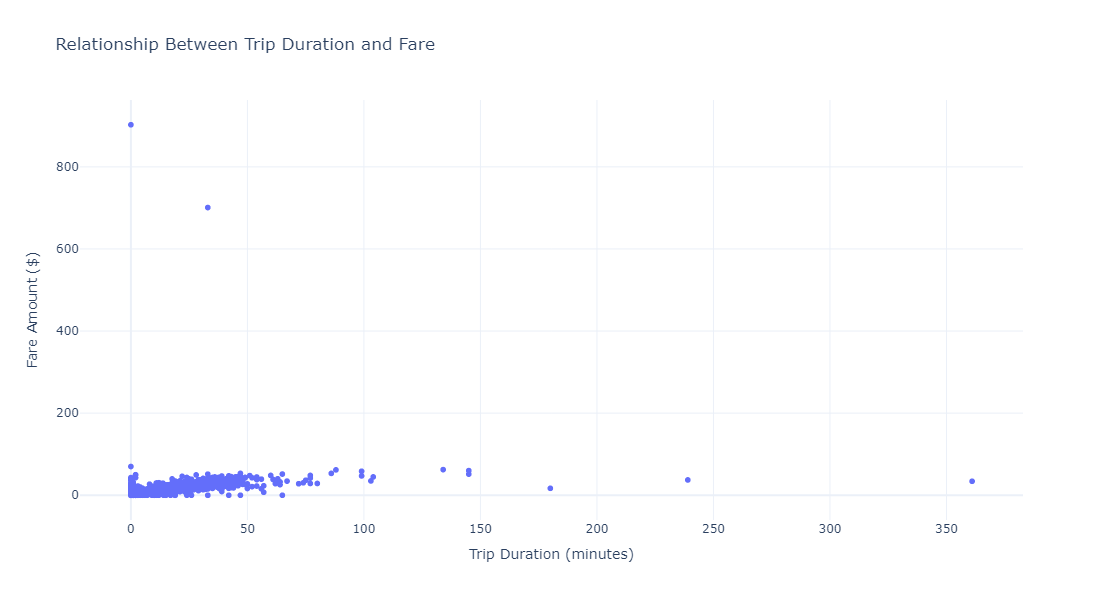

In [31]:
from google.cloud import bigquery
import pandas as pd
import plotly.express as px

client = bigquery.Client()

# Query to explore trip duration and fare
query = """
SELECT trip_seconds, fare
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_seconds IS NOT NULL AND fare IS NOT NULL
LIMIT 10000;
"""

# Run the query and convert to DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Convert trip_seconds to minutes
df['trip_minutes'] = df['trip_seconds'] / 60

# Plotting
fig = px.scatter(df, x='trip_minutes', y='fare',
                 title='Relationship Between Trip Duration and Fare',
                 labels={'trip_minutes': 'Trip Duration (minutes)', 'fare': 'Fare Amount ($)'},
                 template='plotly_white')
fig.update_layout(autosize=False, width=1100, height=600)
fig.show()

### Insights Derived from the Analysis
The scatter plot shows a positive correlation between trip duration and fare, particularly for shorter trips where the relationship is more pronounced. As trip durations increase, fare increments tend to stabilize, indicating a possible flat rate or capped pricing structure for longer trips. Notable outliers suggest exceptions or special cases, such as very long trips that do not correspondingly increase in fare.


### Implications for Modeling and Business Objectives
These insights imply that any predictive fare model should account for the nonlinear relationship between duration and fare, especially to handle long trips appropriately. For business strategies, this analysis could inform a revision of fare calculation methods to ensure fairness and competitiveness, possibly incorporating tiered pricing based on trip duration



.

## Average Tips by Hour of Day

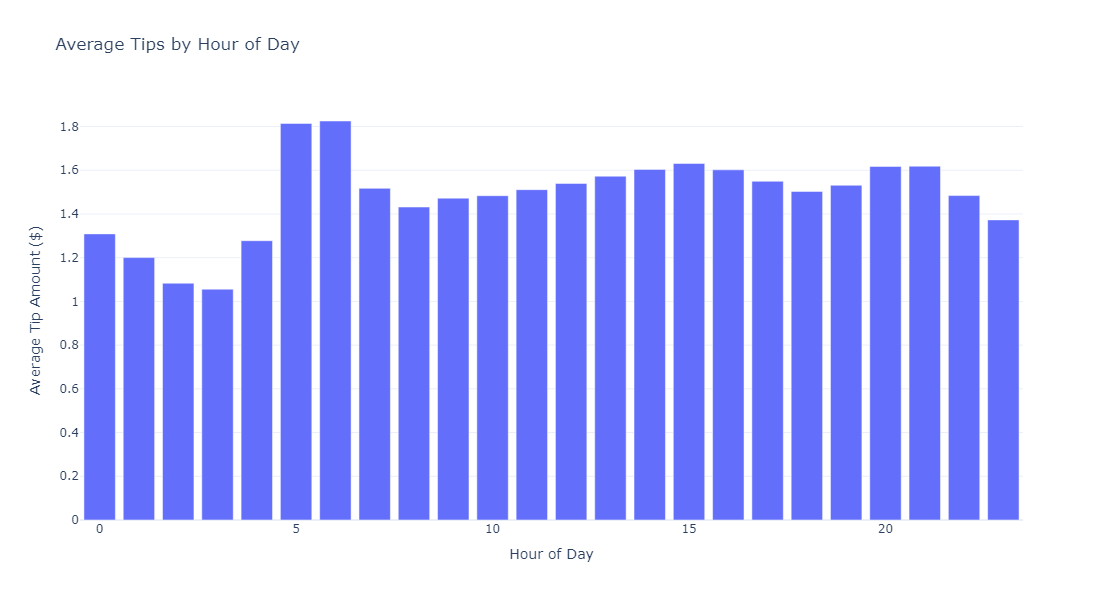

In [32]:
from google.cloud import bigquery
import pandas as pd
import plotly.express as px

client = bigquery.Client()

# Query to examine tips by time of day
query = """
SELECT EXTRACT(HOUR FROM trip_start_timestamp) AS hour_of_day, AVG(tips) AS avg_tips
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE tips IS NOT NULL
GROUP BY hour_of_day
ORDER BY hour_of_day;
"""

# Run the query and convert to DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Plotting
fig = px.bar(df, x='hour_of_day', y='avg_tips',
             title='Average Tips by Hour of Day',
             labels={'hour_of_day': 'Hour of Day', 'avg_tips': 'Average Tip Amount ($)'},
             template='plotly_white')
fig.update_layout(autosize=False, width=1100, height=600)
fig.show()

### Insights Derived from the Analysis
The bar chart reveals that tips peak in the early morning hours, particularly around 4 AM and 5 AM, likely corresponding with late-night shifts ending or early morning commutes beginning. Tips then generally decrease throughout the morning rush, increase slightly in the evening, and taper off late at night. This pattern may reflect higher satisfaction or gratitude for services during less convenient hours, or simply higher rates charged during these times, affecting the total tip amount.

### Implications for Modeling and Business Objectives
The insights into tipping behavior by time of day can influence how taxi services are scheduled and managed. For business strategies, incentivizing drivers to work during high-tip hours could improve service availability when it's most appreciated by customers. Additionally, this tipping data can be integrated into fare prediction models to provide more accurate estimates that include likely tip amounts.

## Average Fare and Tips by Payment Type

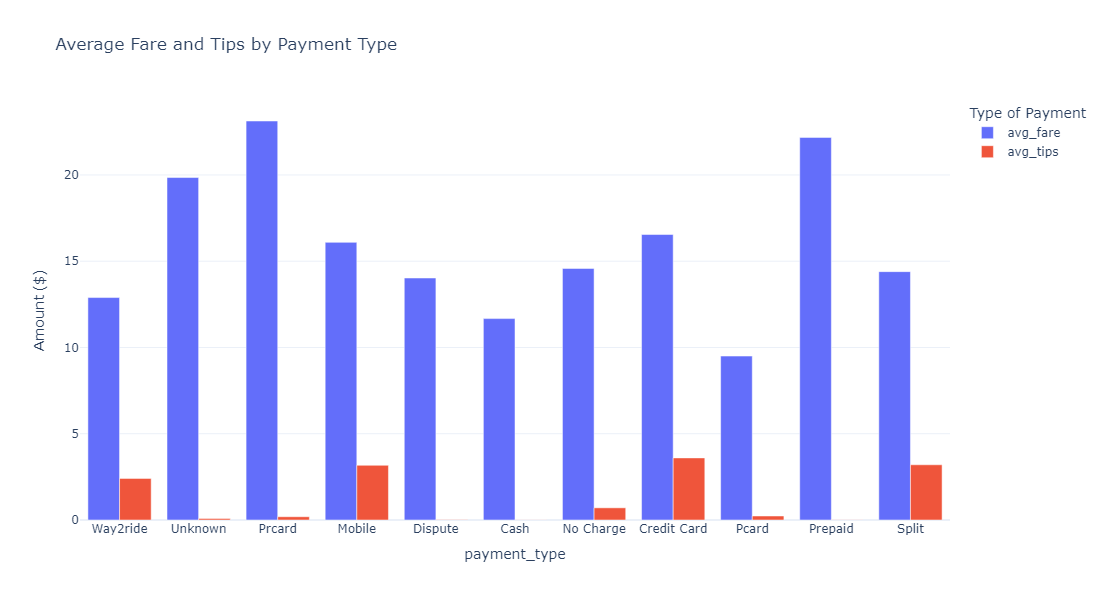

In [33]:
from google.cloud import bigquery
import pandas as pd
import plotly.express as px

client = bigquery.Client()

# Query to explore fare and tips by payment type
query = """
SELECT payment_type, AVG(fare) AS avg_fare, AVG(tips) AS avg_tips
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE fare IS NOT NULL AND tips IS NOT NULL
GROUP BY payment_type;
"""

# Run the query and convert to DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Plotting
fig = px.bar(df, x='payment_type', y=['avg_fare', 'avg_tips'],
             title='Average Fare and Tips by Payment Type',
             barmode='group',
             labels={'value': 'Amount ($)', 'variable': 'Type of Payment'},
             template='plotly_white')
fig.update_layout(autosize=False, width=1100, height=600)
fig.show()

### Insights Derived from the Analysis
The bar chart indicates significant variation in average fares and tips by payment type. Mobile payments and credit cards tend to result in higher average fares and tips compared to cash and other methods. Notably, tips are generally lower for cash payments, which might reflect the convenience and promptness of digital transactions fostering higher tipping. Some payment types like 'Dispute' and 'No Charge' have very low tips, which aligns with customer dissatisfaction or service issues.

### Implications for Modeling and Business Objectives
These insights suggest that encouraging digital payments could enhance revenue from fares and tips. For business strategies, this could mean implementing or improving digital payment systems, offering promotions for first-time digital payment users, or providing incentives for drivers to encourage such payment methods. These strategies could lead to an increase in overall customer satisfaction and revenue.

## Monthly Fare Trends Over Years

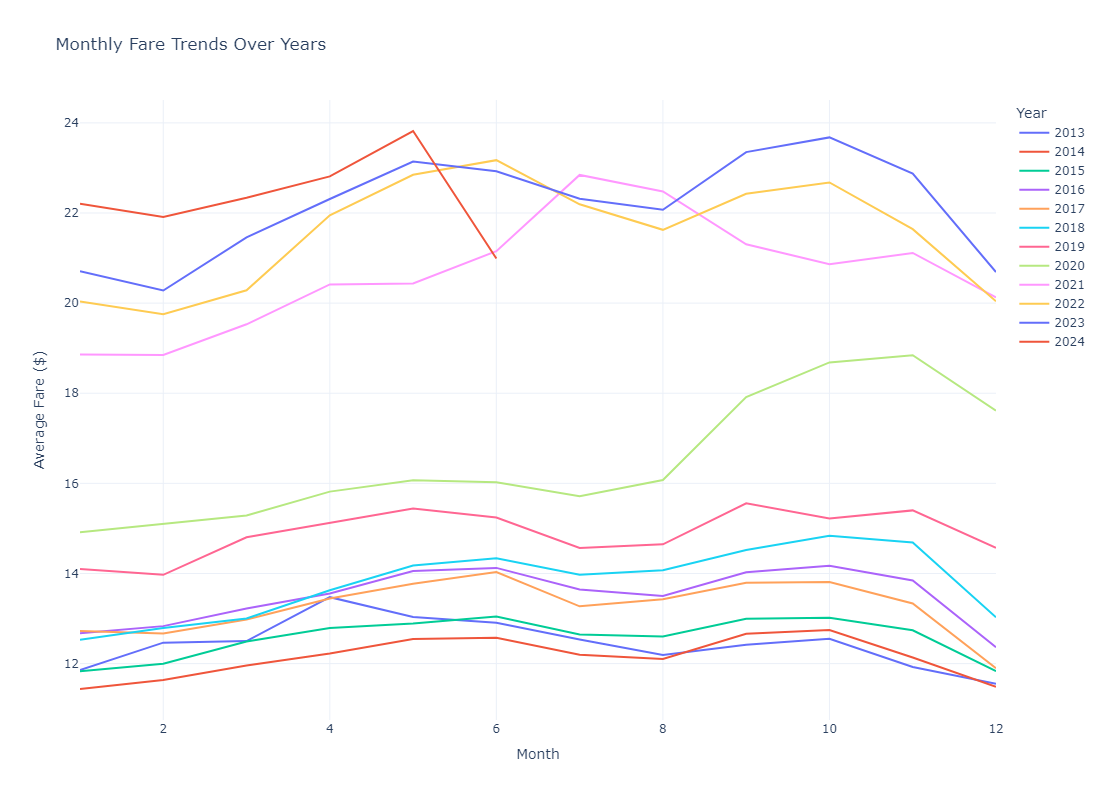

In [34]:
from google.cloud import bigquery
import pandas as pd
import plotly.express as px

client = bigquery.Client()

# Query to extract monthly fare trends
query = """
SELECT EXTRACT(YEAR FROM trip_start_timestamp) AS year, 
       EXTRACT(MONTH FROM trip_start_timestamp) AS month, 
       AVG(fare) AS avg_fare
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE fare IS NOT NULL
GROUP BY year, month
ORDER BY year, month;
"""

# Run the query and convert to DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Plotting
fig = px.line(df, x='month', y='avg_fare', color='year',
              title='Monthly Fare Trends Over Years',
              labels={'month': 'Month', 'avg_fare': 'Average Fare ($)', 'year': 'Year'},
              template='plotly_white')
fig.update_layout(autosize=False, width=1200, height=800)
fig.show()

### Insights Derived from the Analysis
The line chart shows that while there are consistent patterns within most years, significant spikes or drops in fares in certain years suggest external influences. For example, the sharp increase in average fare in early 2022 could be indicative of a sudden regulatory change, a significant economic event, or a change in the competitive landscape (such as reduced competition or increased demand).

### Implications for Modeling and Business Objectives
Understanding these trends can help taxi companies forecast future fare adjustments and strategize accordingly to optimize profitability. For example, if fare increases are identified as seasonal, companies can adjust their fleet availability and marketing strategies to capitalize on these peak periods. Additionally, anomaly years can be studied in detail to understand the impact of external factors on fare structure, aiding in more resilient business planning.



## Distribution of Trip Durations

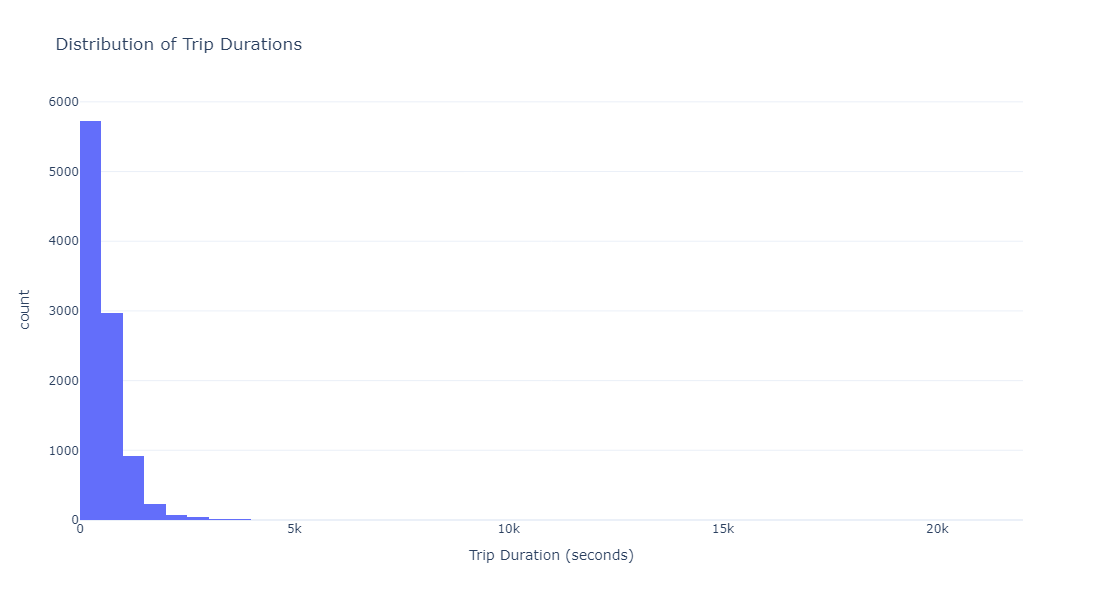

In [35]:
from google.cloud import bigquery
import pandas as pd
import plotly.express as px

client = bigquery.Client()

# Query to explore distribution of trip durations
query = """
SELECT trip_seconds
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_seconds IS NOT NULL
LIMIT 10000;
"""

# Run the query and convert to DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Plotting
fig = px.histogram(df, x='trip_seconds',
                   title='Distribution of Trip Durations',
                   labels={'trip_seconds': 'Trip Duration (seconds)'},
                   template='plotly_white', nbins=50)
fig.update_layout(autosize=False, width=1100, height=600)
fig.show()

### Insights Derived from the Analysis
The histogram indicates a highly skewed distribution with most trips being relatively short, under 10,000 seconds (about 2.8 hours), with a sharp decline in frequency as trip duration increases. This pattern suggests that short, quick trips are far more common than longer journeys, which could influence everything from fleet deployment to promotional offers.

### Implications for Modeling and Business Objectives
These findings can guide taxi companies in customizing their service offerings based on typical trip lengths. For instance, if most trips are short, it might be beneficial to prioritize quick turnaround times and perhaps introduce a pricing model that optimizes revenue from these shorter trips. Moreover, understanding trip duration patterns can help in planning logistics, such as positioning vehicles in areas frequently demanding short rides.

## Impact of Tolls on Total Fares

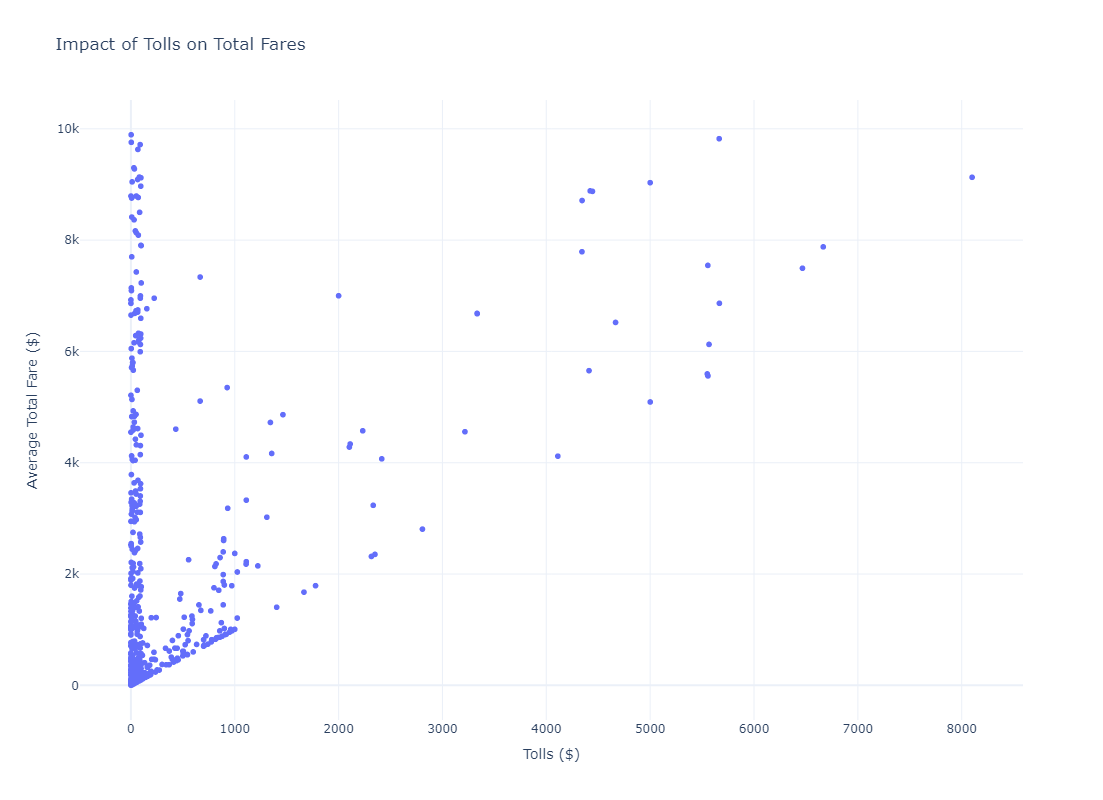

In [36]:
from google.cloud import bigquery
import pandas as pd
import plotly.express as px

client = bigquery.Client()

# Query to examine the impact of tolls on total fares
query = """
SELECT tolls, AVG(trip_total) AS avg_trip_total
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE tolls IS NOT NULL
GROUP BY tolls
ORDER BY tolls;
"""

# Run the query and convert to DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Plotting
fig = px.scatter(df, x='tolls', y='avg_trip_total',
                 title='Impact of Tolls on Total Fares',
                 labels={'tolls': 'Tolls ($)', 'avg_trip_total': 'Average Total Fare ($)'},
                 template='plotly_white')
fig.update_layout(autosize=False, width=1100, height=800)
fig.show()

### Insights Derived from the Analysis
The scatter plot reveals a positive correlation between the amount of tolls paid and the total fare, particularly noticeable at lower toll rates. As tolls increase, the total fare also tends to increase, but the relationship shows wide variability, particularly at higher toll levels where fewer data points are present. This variability could be influenced by different trip lengths, destinations, or traffic conditions affecting the total fare independently of the tolls.

### Implications for Modeling and Business Objectives
The insights from this analysis can inform decisions on fare adjustments or promotional offers that might mitigate the impact of high tolls on customers. For taxi companies, optimizing routes to minimize toll costs could enhance customer satisfaction and competitiveness. Additionally, these findings could be used to advocate for policy adjustments regarding toll pricing, especially if they disproportionately affect taxi services.

## Fare Variability by Pickup Community Area

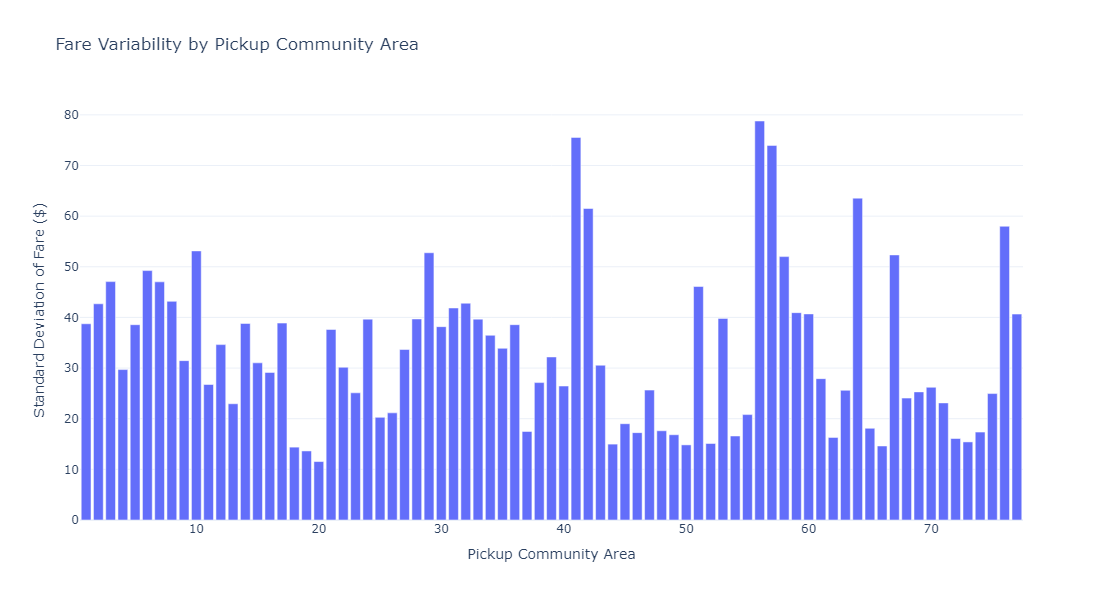

In [37]:
from google.cloud import bigquery
import pandas as pd
import plotly.express as px

client = bigquery.Client()

# Query to examine fare variability by pickup community area
query = """
SELECT pickup_community_area, STDDEV(fare) AS fare_stddev
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE fare IS NOT NULL AND pickup_community_area IS NOT NULL
GROUP BY pickup_community_area
ORDER BY fare_stddev DESC;
"""

# Run the query and convert to DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Plotting
fig = px.bar(df, x='pickup_community_area', y='fare_stddev',
             title='Fare Variability by Pickup Community Area',
             labels={'pickup_community_area': 'Pickup Community Area', 'fare_stddev': 'Standard Deviation of Fare ($)'},
             template='plotly_white')
fig.update_layout(autosize=False, width=1100, height=600)
fig.show()

### Insights Derived from the Analysis
The bar chart displays significant differences in fare variability between community areas. Some areas show high variability, suggesting a wide range of fares that could be influenced by factors like trip length, traffic conditions, or different rates applied by drivers. Lower variability areas might indicate more consistent pricing, possibly due to shorter, more uniform trip distances or better regulation adherence.

### Implications for Modeling and Business Objectives
Understanding where fare variability is high can help taxi companies investigate the causes and potentially standardize fare calculations to ensure fairness and transparency. This could improve customer satisfaction and trust in the service. Additionally, areas with high variability might benefit from targeted marketing strategies to increase ridership and normalize earnings for drivers.

## Average Tip Amount by Taxi Company

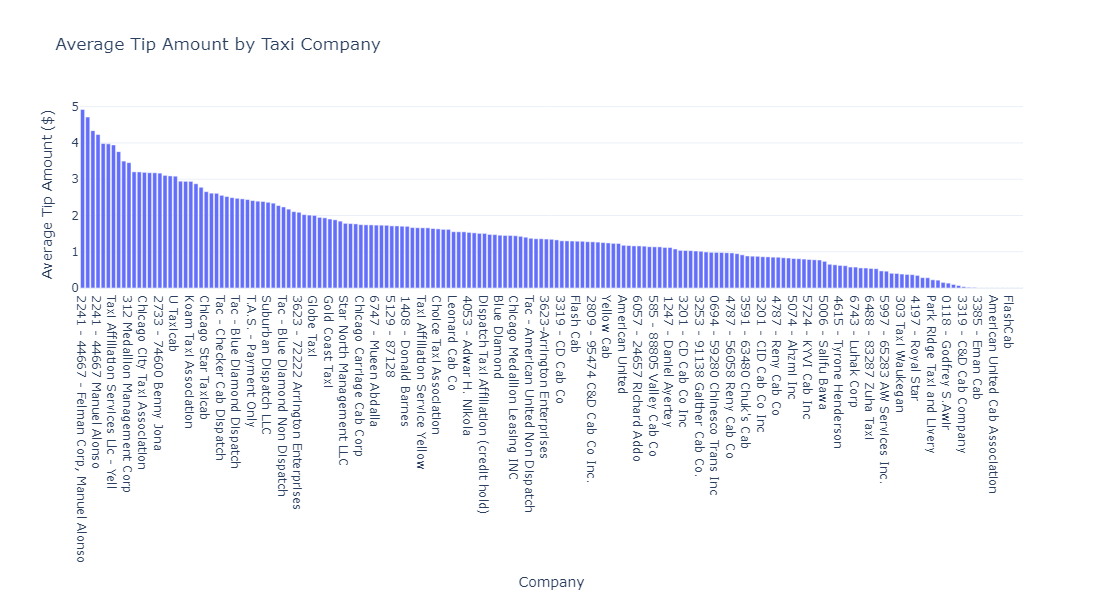

In [38]:
from google.cloud import bigquery
import pandas as pd
import plotly.express as px

client = bigquery.Client()

# Query to analyze average tip amount by taxi company
query = """
SELECT company, AVG(tips) AS avg_tips
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE tips IS NOT NULL
GROUP BY company
ORDER BY avg_tips DESC;
"""

# Run the query and convert to DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Plotting
fig = px.bar(df, x='company', y='avg_tips',
             title='Average Tip Amount by Taxi Company',
             labels={'company': 'Company', 'avg_tips': 'Average Tip Amount ($)'},
             template='plotly_white')
fig.update_layout(autosize=False, width=1100, height=600)
fig.show()

### Insights Derived from the Analysis
The bar chart shows a significant variation in average tips between companies. Some companies exhibit notably higher average tips, which could suggest better customer service or more strategic operations, such as servicing more lucrative routes or clientele. Conversely, companies with lower average tips might need to assess their customer service strategies or driver satisfaction levels.

### Implications for Modeling and Business Objectives
Understanding tip variations can guide taxi companies in targeting improvements in driver training, customer service, and operational strategies to enhance tip earnings, which can increase overall driver satisfaction and retention. Additionally, this data can help companies position themselves more competitively by highlighting their strengths in customer satisfaction in marketing efforts.

## Number of Trips by Hour of Day

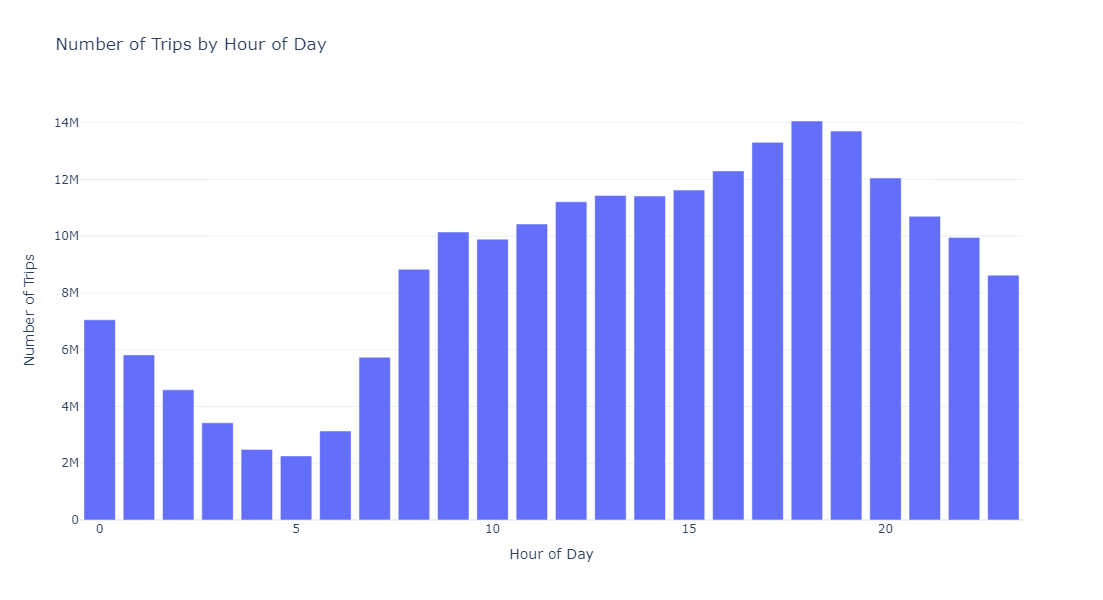

In [39]:
from google.cloud import bigquery
import pandas as pd
import plotly.express as px

client = bigquery.Client()

# Query to analyze trip frequency by hour of day
query = """
SELECT EXTRACT(HOUR FROM trip_start_timestamp) AS hour_of_day, COUNT(*) AS trip_count
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
GROUP BY hour_of_day
ORDER BY hour_of_day;
"""

# Run the query and convert to DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Plotting
fig = px.bar(df, x='hour_of_day', y='trip_count',
             title='Number of Trips by Hour of Day',
             labels={'hour_of_day': 'Hour of Day', 'trip_count': 'Number of Trips'},
             template='plotly_white')
fig.update_layout(autosize=False, width=1100, height=600)
fig.show()

### Insights Derived from the Analysis
The bar chart shows that trip frequency increases steadily from the early morning hours, peaks during the late afternoon and early evening, and then gradually decreases through the night. The highest number of trips typically occurs around 6 PM, indicating a significant demand during the evening rush hour. Conversely, the lowest trip frequencies are observed in the early morning hours, around 3 AM to 5 AM.

### Implications for Modeling and Business Objectives
Understanding these patterns can help taxi companies make informed decisions regarding driver scheduling, fleet management, and dynamic pricing strategies. For instance, incentives could be offered to drivers to work during peak hours or discounts to customers during off-peak hours to balance demand. Additionally, this information can aid in forecasting demand and preparing for event-driven spikes in taxi usage.

## Geospatial Distribution of Average Fares

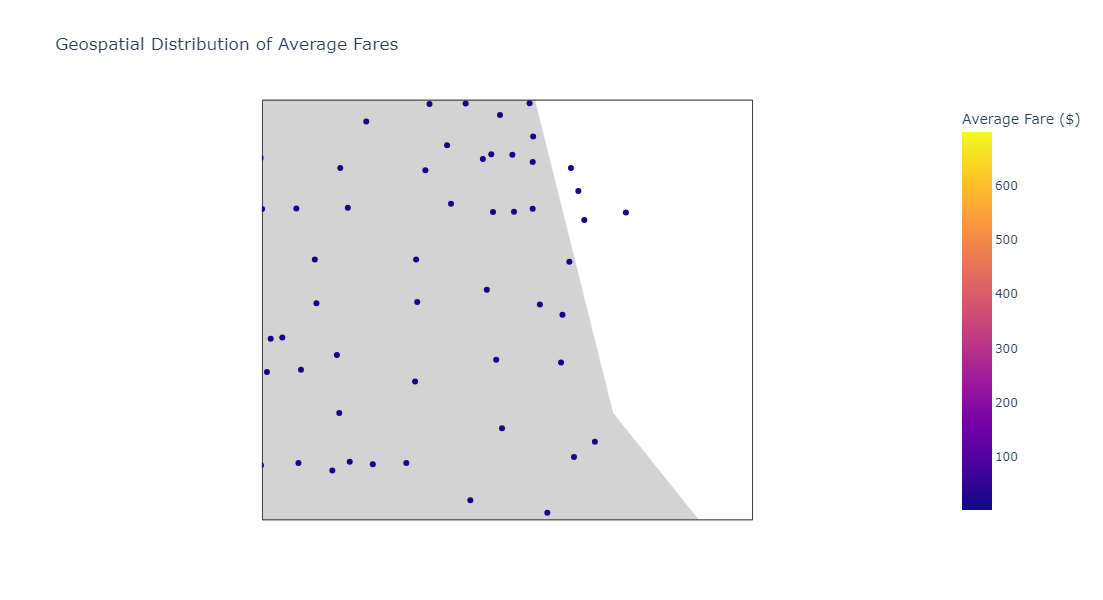

In [40]:
from google.cloud import bigquery
import pandas as pd
import plotly.express as px

client = bigquery.Client()

# Query to analyze geospatial distribution of fares
query = """
SELECT pickup_latitude, pickup_longitude, AVG(fare) AS avg_fare
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL
GROUP BY pickup_latitude, pickup_longitude;
"""

# Run the query and convert to DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Plotting
fig = px.scatter_geo(df, lat='pickup_latitude', lon='pickup_longitude', color='avg_fare',
                     title='Geospatial Distribution of Average Fares',
                     labels={'avg_fare': 'Average Fare ($)'},
                     template='plotly_white')
# Fine-tuning the geo options for a closer view
fig.update_geos(
    resolution=50,  # Higher resolution for better map detail
    showcountries=True, showcoastlines=True, showland=True, landcolor='lightgrey',
    lonaxis_range=[-88.2, -87.5],  # Slightly expanded range for more room to pan
    lataxis_range=[41.6, 42.2]  # Expanded latitude range
)

fig.update_layout(
    geo=dict(
        projection_scale=10,  # Adjust scale for zooming closer to Chicago
        center=dict(lat=41.8781, lon=-87.6298)  # Ensures that Chicago remains at the center
    ),
    autosize=True, width=1100, height=600)

fig.show()

### Insights Derived from the Analysis
The geospatial plot reveals distinct patterns in fare distribution:

Higher fares are predominantly observed in central and downtown areas, likely reflecting higher demand, longer trip distances, or premium pricing due to the commercial nature of these areas.
Lower average fares are noticeable in outlying regions, possibly due to shorter trips or lower demand.

### Implications for Modeling and Business Objectives
The insights from this spatial analysis can guide strategic decisions regarding service allocation, dynamic pricing models, and marketing strategies tailored to specific geographic areas. Taxi companies could use this data to optimize their operations by increasing fleet availability in high-fare areas or adjusting fare structures to better compete in lower-fare regions.

## Tip Percentage of Fare by Day of Week

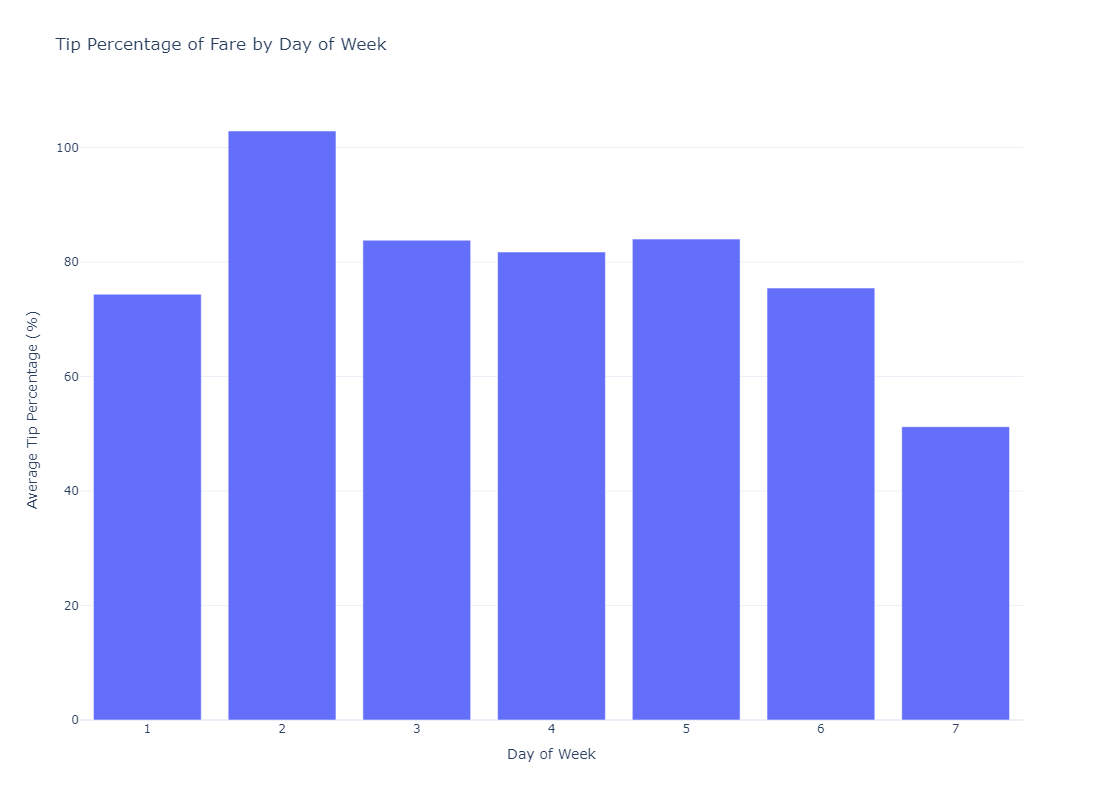

In [41]:
from google.cloud import bigquery
import pandas as pd
import plotly.express as px

client = bigquery.Client()

# Query to analyze tip percentage by day of week
query = """
SELECT EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS day_of_week, 
       AVG(tips / fare * 100) AS avg_tip_percent
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE fare > 0 AND tips IS NOT NULL
GROUP BY day_of_week
ORDER BY day_of_week;
"""

# Run the query and convert to DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Plotting
fig = px.bar(df, x='day_of_week', y='avg_tip_percent',
             title='Tip Percentage of Fare by Day of Week',
             labels={'day_of_week': 'Day of Week', 'avg_tip_percent': 'Average Tip Percentage (%)'},
             template='plotly_white')
fig.update_layout(autosize=False, width=1200, height=800)
fig.show()

### Insights Derived from the Analysis
The bar chart indicates significant variability in tip percentages by day of the week. The highest tip percentages are observed in the middle of the week, with a notable peak on Wednesday, suggesting higher satisfaction or possibly more favorable trip conditions (like less traffic or quicker service). The lowest tip percentages occur on Sunday, which might reflect different trip types, such as leisurely activities where price sensitivity is higher.

### Implications for Modeling and Business Objectives
Understanding these trends can help taxi companies tailor their service offerings to enhance customer satisfaction and optimize driver schedules to maximize income. For instance, incentives could be offered to drivers to work on days with typically higher tips, or special promotions could be targeted at days with lower average tips to boost customer engagement and tipping behavior.





## Total Fare Amounts by Payment Type

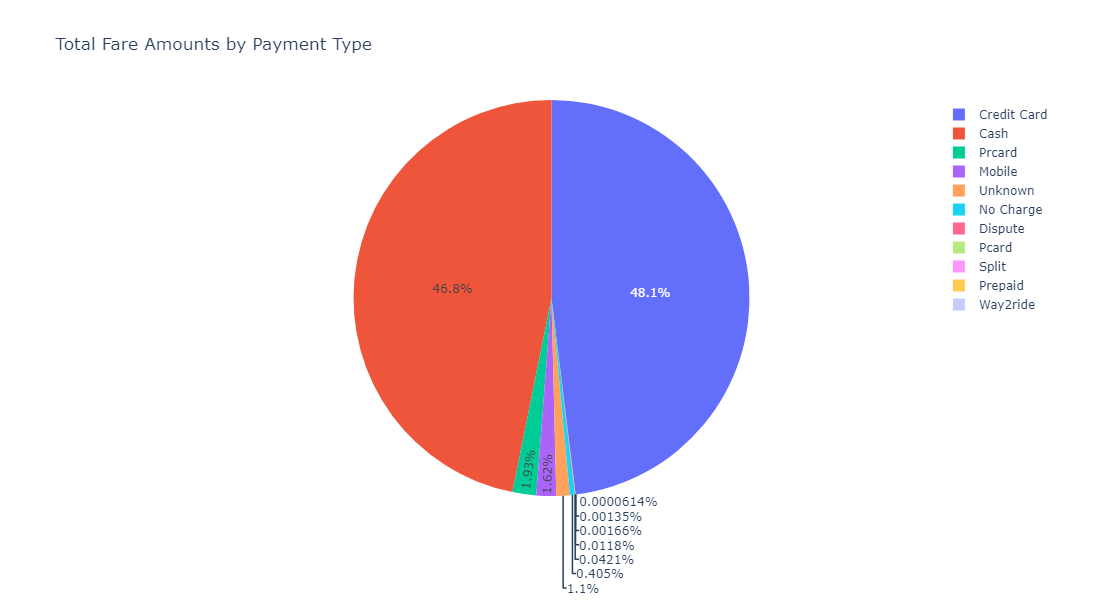

In [42]:
from google.cloud import bigquery
import pandas as pd
import plotly.express as px

client = bigquery.Client()

# Query to analyze total fare amounts by payment type
query = """
SELECT payment_type, SUM(fare) AS total_fare
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
GROUP BY payment_type;
"""

# Run the query and convert to DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Plotting
fig = px.pie(df, names='payment_type', values='total_fare',
             title='Total Fare Amounts by Payment Type',
             template='plotly_white')
fig.update_layout(autosize=False, width=1100, height=600)
fig.show()

### Insights Derived from the Analysis
The pie chart highlights that credit card payments constitute a slightly larger portion of total fare collections compared to cash, with both payment types dominating the market. This suggests a high acceptance and reliance on digital payment methods alongside traditional cash transactions.

### Implications for Modeling and Business Objectives
Understanding payment preferences can guide operational improvements, such as:
Enhancing mobile payment systems or incentivizing their use if they represent a smaller portion of payments but are preferred by customers for their convenience.
Tailoring financial reconciliation processes to handle the majority payment types more efficiently.
Developing targeted marketing strategies that promote preferred payment methods to streamline operations and improve customer satisfaction.

## Average Fare by Day and Night

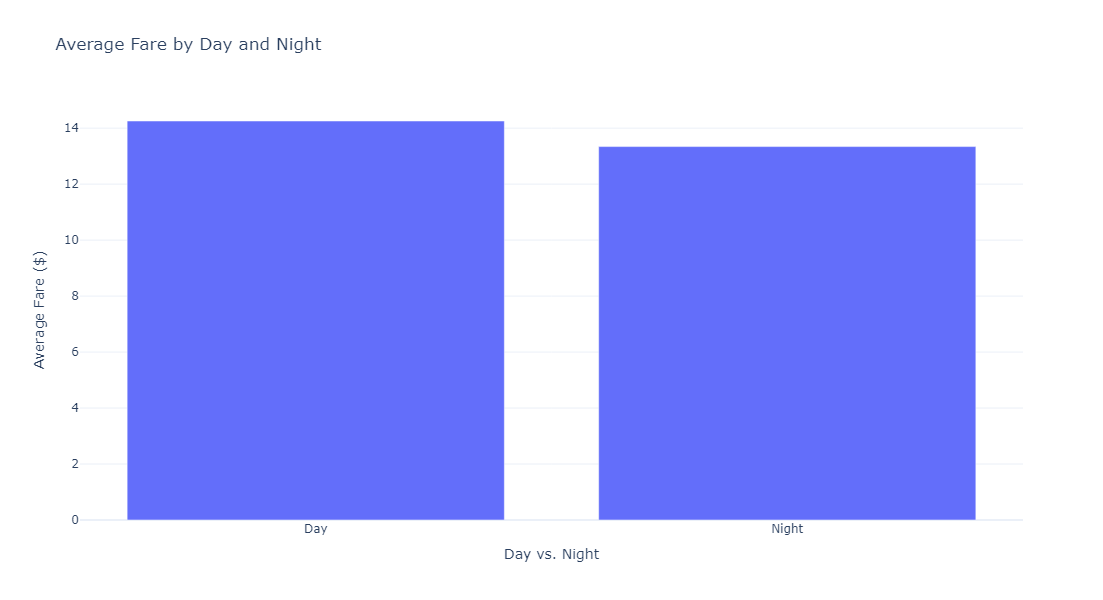

In [43]:
from google.cloud import bigquery
import pandas as pd
import plotly.express as px

client = bigquery.Client()

# Query to differentiate fares between day and night
query = """
SELECT 
    CASE 
        WHEN EXTRACT(HOUR FROM trip_start_timestamp) BETWEEN 6 AND 18 THEN 'Day'
        ELSE 'Night'
    END AS day_night,
    AVG(fare) AS avg_fare
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
GROUP BY day_night;
"""

# Run the query and convert to DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Plotting
fig = px.bar(df, x='day_night', y='avg_fare',
             title='Average Fare by Day and Night',
             labels={'day_night': 'Day vs. Night', 'avg_fare': 'Average Fare ($)'},
             template='plotly_white')
fig.update_layout(autosize=False, width=1100, height=600)
fig.show()


### Insights Derived from the Analysis
The bar chart illustrates a slight difference in average fares between day and night, with daytime fares being marginally higher. This could reflect higher daytime demand or increased operational costs during these hours, such as higher traffic congestion leading to longer trip times.

### Implications for Modeling and Business Objectives
The insights from this analysis suggest that fare models could benefit from including time-of-day as a variable to adjust fares dynamically. For business strategies, this could support arguments for differential pricing strategies to manage demand and maximize profitability during peak and off-peak hours.

## Fare and Tip Trends Over Years

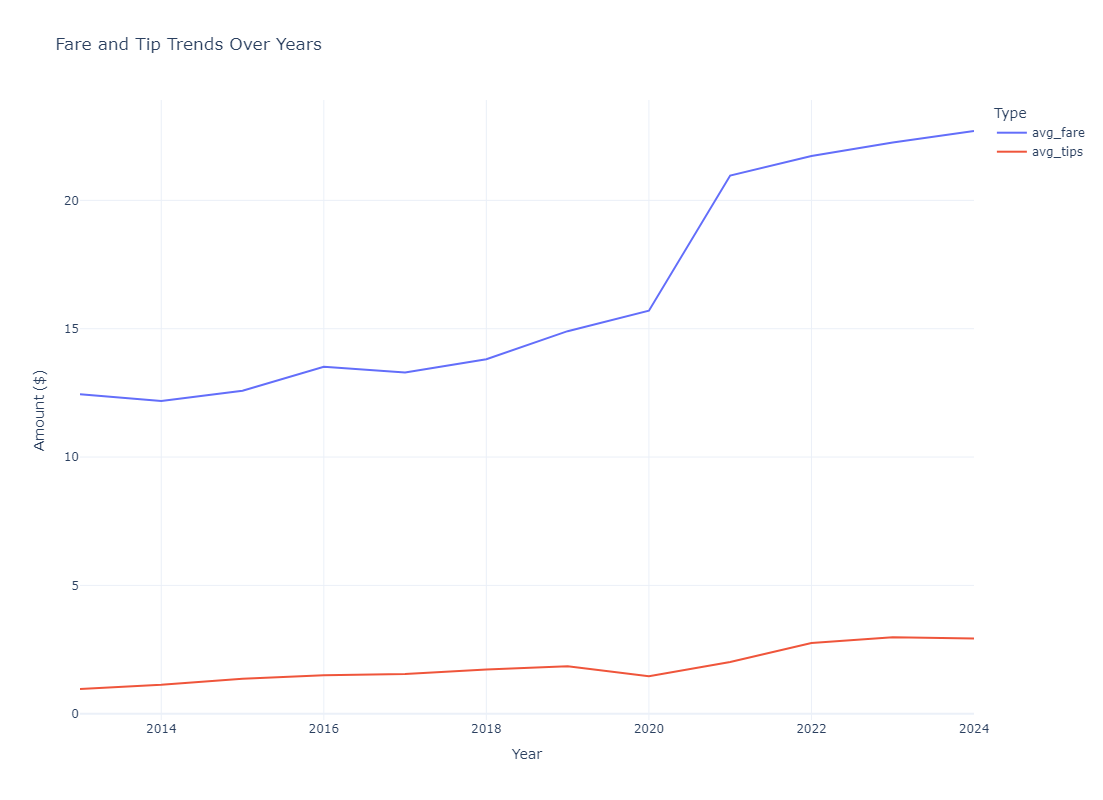

In [44]:
from google.cloud import bigquery
import pandas as pd
import plotly.express as px

client = bigquery.Client()

# Query to analyze fare and tip trends over years
query = """
SELECT EXTRACT(YEAR FROM trip_start_timestamp) AS year, 
       AVG(fare) AS avg_fare, 
       AVG(tips) AS avg_tips
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
GROUP BY year
ORDER BY year;
"""

# Run the query and convert to DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Plotting
fig = px.line(df, x='year', y=['avg_fare', 'avg_tips'], 
              title='Fare and Tip Trends Over Years',
              labels={'year': 'Year', 'value': 'Amount ($)', 'variable': 'Type'},
              template='plotly_white')
fig.update_layout(autosize=False, width=1200, height=800)
fig.show()

### Preprocessing and Feature Selection Implications:
The visualization suggests that year is an important feature for trend analysis in the taxi industry, potentially influencing fare and tip models. It also highlights the need for preprocessing to adjust for inflation or other economic factors when analyzing financial trends over time.

### Impact of Data Exploration on Decisions:
Understanding the trends in fares and tips can help taxi companies and policymakers make informed decisions regarding pricing strategies, driver compensation, and service improvements. For example, the stable tip trends despite rising fares might prompt initiatives to enhance service quality or customer satisfaction to boost tipping rates.


###  This analysis is critical for strategic planning within the taxi industry, helping stakeholders anticipate future changes and adapt their business strategies accordingly.


.

## Total Fare Amounts by Payment Type

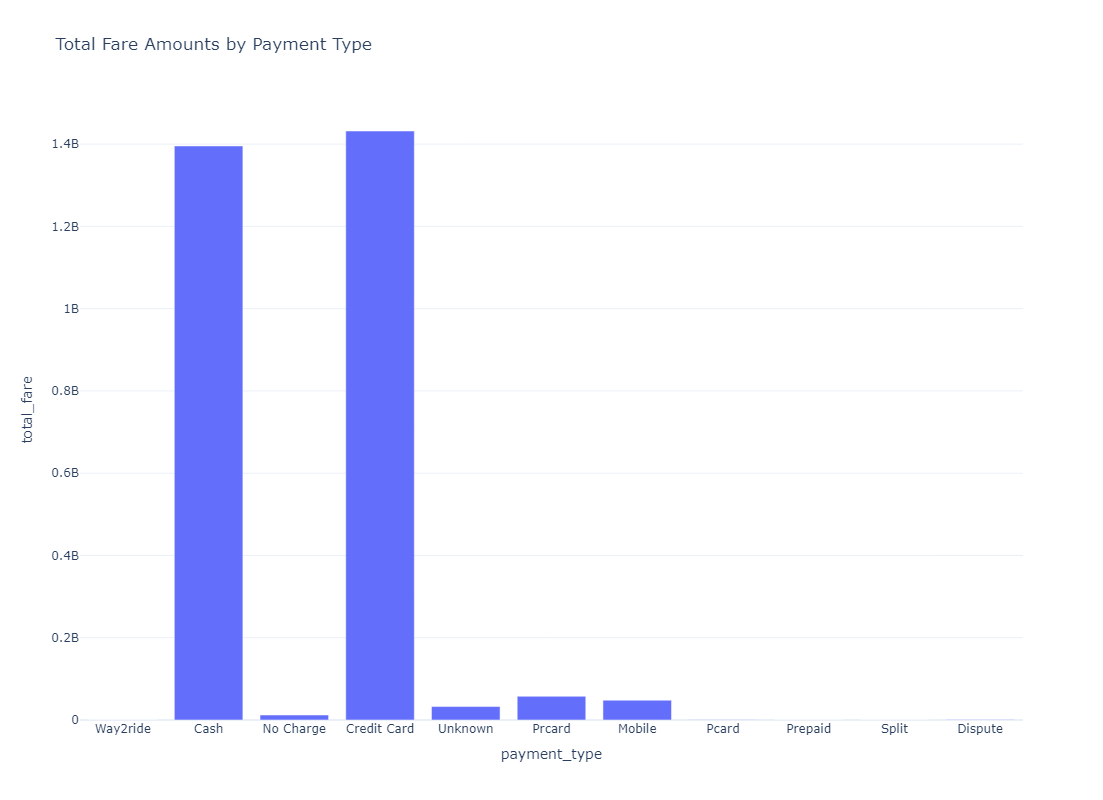

In [45]:
from google.cloud import bigquery
import pandas as pd
import plotly.express as px

client = bigquery.Client()

# Query to analyze total fare amounts by payment type
query = """
SELECT payment_type, SUM(fare) AS total_fare
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
GROUP BY payment_type;
"""

# Run the query and convert to DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Plotting
# fig = px.pie(df, names='payment_type', values='total_fare',
#              title='Total Fare Amounts by Payment Type',
#              template='plotly_white')
# fig.update_layout(autosize=False, width=1100, height=800)

fig = px.bar(df, x='payment_type', y='total_fare',
             title='Total Fare Amounts by Payment Type',
             template='plotly_white')

fig.update_layout(autosize=False, width=1100, height=800)


fig.show()


### Insights Derived from the Analysis
The pie chart highlights that credit card payments constitute a slightly larger portion of total fare collections compared to cash, with both payment types dominating the market. This suggests a high acceptance and reliance on digital payment methods alongside traditional cash transactions.

### Implications for Modeling and Business Objectives
Understanding payment preferences can guide operational improvements, such as:
Enhancing mobile payment systems or incentivizing their use if they represent a smaller portion of payments but are preferred by customers for their convenience.
Tailoring financial reconciliation processes to handle the majority payment types more efficiently.
Developing targeted marketing strategies that promote preferred payment methods to streamline operations and improve customer satisfaction.

## Frequency of Trips by Pickup Community Area

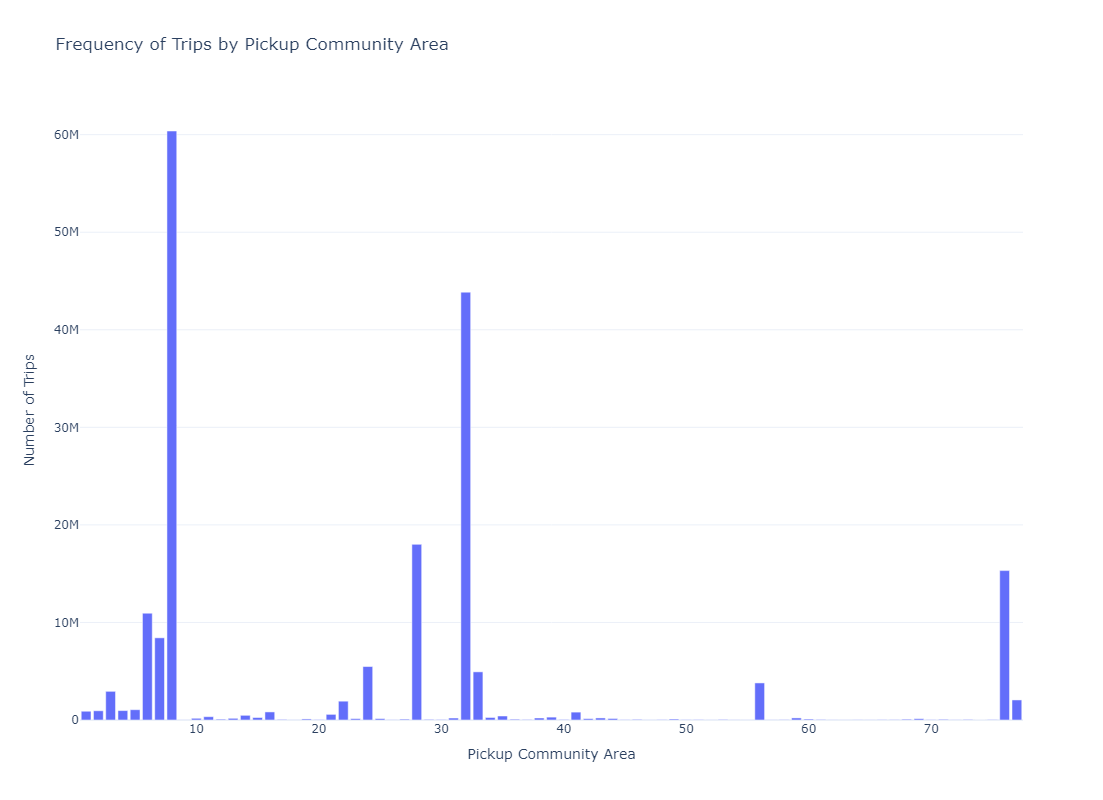

In [46]:
from google.cloud import bigquery
import pandas as pd
import plotly.express as px

client = bigquery.Client()

# Query to analyze trip frequency by pickup community area
query = """
SELECT pickup_community_area, COUNT(*) AS num_trips
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE pickup_community_area IS NOT NULL
GROUP BY pickup_community_area
ORDER BY num_trips DESC;
"""

# Run the query and convert to DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Plotting
fig = px.bar(df, x='pickup_community_area', y='num_trips',
             title='Frequency of Trips by Pickup Community Area',
             labels={'pickup_community_area': 'Pickup Community Area', 'num_trips': 'Number of Trips'},
             template='plotly_white')
fig.update_layout(autosize=False, width=1200, height=800)
fig.show()

### Insights Derived from the Analysis
The bar chart demonstrates that certain community areas, notably those centrally located or near major transit hubs, experience significantly higher numbers of trips. In contrast, outlying areas see fewer trips. This distribution is influenced by factors such as accessibility, population density, and proximity to key city attractions or business districts.

#### Implications for Modeling and Business Objectives
Insights from this analysis could drive strategic decisions in service allocation, marketing, and pricing. For instance, taxi companies could deploy more vehicles or offer promotional rates in areas with lower trip frequencies to increase market penetration. Conversely, in high-traffic areas, dynamic pricing models could be utilized to optimize revenue during peak times.

# Data preprocessing - Feature selection

In [47]:
import warnings
warnings.filterwarnings('ignore')

# !pip3 install gcsfs
# !pip3 install statsmodels

In [48]:
import gcsfs
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

# from sklearn.datasets import make_regression

## load the dataset

In [49]:
file_name = 'Final_Chicago_Train.csv'

# load the CSV file into a DataFrame
df = pd.read_csv(file_name)

# Display the DataFrame
df.head()

unique_key  \
0  7313414f43d987fe6d6573e2502dde4736c3f31a   
1  c58abe86d22f4f05ab7de56bb3c2d6f43bc0539f   
2  d317a3c3f3b08bc28608e2bce24eaf02b3b90451   
3  b2c1dc188550a0dee241e4af9a48dde35013e20e   
4  be0420d11c3bc4ea210ef7a26ea44324a58c7728   

                                             taxi_id  \
0  7ccdd31cb639a6b99145aa426c34b9c98cb3634d8ecc2f...   
1  7197b1e633c906b0a6284fc332c209fc3d105b9b74a6dc...   
2  70c9780e638103d4e1bc1ac366e7dae471713d64d880bf...   
3  f1ed8794238deb1c8f7c3759aa096ae20e3e769cc4c9ad...   
4  a94a7aa5204a6900f6f2a9d3a14885bed12f05228a4482...   

        trip_start_timestamp         trip_end_timestamp  trip_seconds  \
0  2019-03-02 20:15:00+00:00  2019-03-02 20:30:00+00:00           420   
1  2019-01-19 15:45:00+00:00  2019-01-19 15:45:00+00:00           120   
2  2019-01-29 18:00:00+00:00  2019-01-29 18:15:00+00:00          1560   
3  2019-01-02 09:30:00+00:00  2019-01-02 10:00:00+00:00          1560   
4  2019-02-10 01:30:00+00:00  2019-02-10 01:45:00+00:00           694   

   trip_miles  pickup_census_tract  dropoff_census_tract  \
0         1.4         1.703132e+10          1.703108e+10   
1         0.4         1.703108e+10          1.703108e+10   
2        10.5         1.703198e+10                   NaN   
3        12.7         1.703198e+10          1.703108e+10   
4         5.2                  NaN                   NaN   

   pickup_community_area  dropoff_community_area  ...  \
0                   32.0                     8.0  ...   
1                    8.0                     8.0  ...   
2                   76.0                     NaN  ...   
3                   56.0                     8.0  ...   
4                    7.0                     3.0  ...   

                           company  pickup_latitude  pickup_longitude  \
0        Taxi Affiliation Services        41.877406        -87.621972   
1          Choice Taxi Association        41.898332        -87.620763   
2        Star North Management LLC        41.979071        -87.903040   
3                 Metro Jet Taxi A        41.785999        -87.750934   
4  Taxi Affiliation Service Yellow        41.922686        -87.649489   

                        pickup_location  dropoff_latitude dropoff_longitude  \
0  POINT (-87.6219716519 41.8774061234)         41.898332        -87.620763   
1  POINT (-87.6207628651 41.8983317935)         41.899156        -87.626211   
2  POINT (-87.9030396611 41.9790708201)               NaN               NaN   
3   POINT (-87.7509342894 41.785998518)         41.892508        -87.626215   
4  POINT (-87.6494887289 41.9226862843)         41.965812        -87.655879   

                       dropoff_location  trip_start_day  trip_start_month  \
0  POINT (-87.6207628651 41.8983317935)               2                 3   
1  POINT (-87.6262105324 41.8991556134)              19                 1   
2                                   NaN              29                 1   
3  POINT (-87.6262149064 41.8925077809)               2                 1   
4    POINT (-87.6558787862 41.96581197)              10                 2   

  trip_start_hour  
0              20  
1              15  
2              18  
3               9  
4               1  

[5 rows x 26 columns]

In [50]:
df.dtypes

unique_key                 object
taxi_id                    object
trip_start_timestamp       object
trip_end_timestamp         object
trip_seconds                int64
trip_miles                float64
pickup_census_tract       float64
dropoff_census_tract      float64
pickup_community_area     float64
dropoff_community_area    float64
fare                      float64
tips                      float64
tolls                     float64
extras                    float64
trip_total                float64
payment_type               object
company                    object
pickup_latitude           float64
pickup_longitude          float64
pickup_location            object
dropoff_latitude          float64
dropoff_longitude         float64
dropoff_location           object
trip_start_day              int64
trip_start_month            int64
trip_start_hour             int64
dtype: object

### Some feature extraction

In [51]:
# Convert the 'trip_start_timestamp' to datetime if it's not already.
df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])

# Extract hour, day, and month from the timestamp
df['trip_start_hour'] = df['trip_start_timestamp'].dt.hour
df['trip_start_day'] = df['trip_start_timestamp'].dt.day
df['trip_start_month'] = df['trip_start_timestamp'].dt.month

In [52]:
# Convert the 'trip_end_timestamp' to datetime if it's not already.
df['trip_end_timestamp'] = pd.to_datetime(df['trip_end_timestamp'])

# Extract hour, day, and month from the timestamp
df['trip_end_hour'] = df['trip_end_timestamp'].dt.hour
df['trip_end_day'] = df['trip_end_timestamp'].dt.day
df['trip_end_month'] = df['trip_end_timestamp'].dt.month

In [53]:
df.shape

(40000, 29)

In [54]:
columns_to_drop = ['unique_key', 'taxi_id', 'trip_start_timestamp', 
                   'trip_end_timestamp', 'dropoff_location', 'pickup_location']
# Dropping unnecessary columns
df= df.drop(columns=columns_to_drop)

In [55]:
df.shape

(40000, 23)

## Data Preprocessing - Encoding and pre-processing

In [56]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [57]:
def one_hot_encoder(values, num_categories):
    """One-hot encode the values."""
    categories = sorted(set(values.dropna()))  # Handle NaN by dropping
    one_hot_encoded = []
    for v in values:
        encoding = [1 if v == category else 0 for category in categories]
        one_hot_encoded.append(encoding)
    return pd.DataFrame(one_hot_encoded, columns=[f"{values.name}_{c}" for c in categories], index=values.index)

In [58]:
def data_preprocessor(df):
    
    numerical_features = ['trip_miles', 'trip_seconds', 'tips', 'tolls', 'extras', 'trip_total']
    bucket_features = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
    categorical_numerical_features = [
        'trip_start_hour', 'trip_start_day', 'trip_start_month',
        'trip_end_hour', 'trip_end_day', 'trip_end_month',
        'pickup_census_tract', 'dropoff_census_tract', 'pickup_community_area',
        'dropoff_community_area'
    ]
    categorical_string_features = ['payment_type', 'company']
    
    # Handling missing values and scaling numerical features
    for feature in numerical_features:
        print(feature)
        df[feature] = SimpleImputer(strategy='mean').fit_transform(df[[feature]])
        df[feature] = StandardScaler().fit_transform(df[[feature]])
    
    # Bucketizing geographical features
    for feature in bucket_features:
        print(feature)
        df[feature] = SimpleImputer(strategy='mean').fit_transform(df[[feature]])
        discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
        df[feature] = discretizer.fit_transform(df[[feature]])
    
    # One-hot encoding for categorical string features
    for feature in categorical_string_features:
        print(feature)
        df_filled = SimpleImputer(strategy='constant', fill_value='missing').fit_transform(df[[feature]].astype(str))
        df_encoded = one_hot_encoder(pd.Series(df_filled.flatten(), name=feature), num_categories=None)
        df = pd.concat([df, df_encoded], axis=1)
        df.drop(columns=[feature], inplace=True)
    
    # One-hot encoding for categorical numerical features
    for feature in categorical_numerical_features:
        print(feature)
        df_filled = SimpleImputer(strategy='most_frequent').fit_transform(df[[feature]].astype(str))
        df_encoded = one_hot_encoder(pd.Series(df_filled.flatten(), name=feature), num_categories=None)
        df = pd.concat([df, df_encoded], axis=1)
        df.drop(columns=[feature], inplace=True)
    
    # Fill missing values for the label (fare)
    df['fare'] = SimpleImputer(strategy='mean').fit_transform(df[['fare']])
    
    return df

In [59]:
# Assuming your DataFrame after dropping columns is named df
df_processed = data_preprocessor(df)

# Now you can display the processed DataFrame
df_processed.head()

trip_miles
trip_seconds
tips
tolls
extras
trip_total
pickup_latitude
pickup_longitude
dropoff_latitude
dropoff_longitude
payment_type
company
trip_start_hour
trip_start_day
trip_start_month
trip_end_hour
trip_end_day
trip_end_month
pickup_census_tract
dropoff_census_tract
pickup_community_area
dropoff_community_area


trip_seconds  trip_miles   fare      tips     tolls    extras  trip_total  \
0     -0.292603   -0.356502   7.25 -0.599747 -0.013333  0.008919   -0.130543   
1     -0.511389   -0.538240   4.25 -0.259484 -0.013333 -0.044673   -0.183190   
2      0.538787    1.297308  27.75  2.445606 -0.013333  0.562706    0.545594   
3      0.538787    1.697130  32.75 -0.599747 -0.013333  0.133968    0.305674   
4     -0.092778    0.334100  15.50 -0.599747 -0.013333 -0.044673   -0.029010   

   pickup_latitude  pickup_longitude  dropoff_latitude  ...  \
0              6.0               7.0               6.0  ...   
1              6.0               7.0               6.0  ...   
2              8.0               0.0               6.0  ...   
3              3.0               4.0               6.0  ...   
4              7.0               6.0               8.0  ...   

   dropoff_community_area_71.0  dropoff_community_area_72.0  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   dropoff_community_area_73.0  dropoff_community_area_74.0  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   dropoff_community_area_75.0  dropoff_community_area_76.0  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   dropoff_community_area_77.0  dropoff_community_area_8.0  \
0                            0                           1   
1                            0                           1   
2                            0                           0   
3                            0                           1   
4                            0                           0   

   dropoff_community_area_9.0  dropoff_community_area_nan  
0                           0                           0  
1                           0                           0  
2                           0                           1  
3                           0                           0  
4                           0                           0  

[5 rows x 702 columns]

In [60]:
df_processed.columns

Index(['trip_seconds', 'trip_miles', 'fare', 'tips', 'tolls', 'extras',
       'trip_total', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
       ...
       'dropoff_community_area_71.0', 'dropoff_community_area_72.0',
       'dropoff_community_area_73.0', 'dropoff_community_area_74.0',
       'dropoff_community_area_75.0', 'dropoff_community_area_76.0',
       'dropoff_community_area_77.0', 'dropoff_community_area_8.0',
       'dropoff_community_area_9.0', 'dropoff_community_area_nan'],
      dtype='object', length=702)

## Defining X & y

In [61]:
# Selecting label column
y = df_processed['fare']

# Dropping label columns 
X = df_processed.drop(columns='fare')


## Train Test Split

In [62]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Fitting various models and evaluation..

In [63]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [64]:
#  defining various regression models.

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [65]:
# Define a function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2

# Evaluate each model
results = {}
for model_name, model in models.items():
    mse, rmse, r2 = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[model_name] = {"MSE": mse, "RMSE": rmse, "R2": r2}

# Print the results
for model_name, metrics in results.items():
    if metrics['R2'] is not None:
        print(f"{model_name} - MSE: {metrics['MSE']:.4f}, RMSE: {metrics['RMSE']:.4f}, R2: {metrics['R2']:.4f}")
    else:
        print(f"{model_name} - MSE: {metrics['MSE']:.4f}, RMSE: {metrics['RMSE']:.4f}")

Linear Regression - MSE: 28779055006029112.0000, RMSE: 169643906.4807, R2: -20290473111863.9961
Decision Tree - MSE: 171.8495, RMSE: 13.1091, R2: 0.8788
Random Forest - MSE: 184.6448, RMSE: 13.5884, R2: 0.8698
Gradient Boosting - MSE: 84.8452, RMSE: 9.2111, R2: 0.9402


#### Here Gradient Boosting model is giving the best result compared to other models. So we are selecting the Gradient Boosting model

## Hyperparameter Tuning

In [66]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [67]:
# Hyperparameter grids
param_grids = {
    "Gradient Boosting": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

# Initialize models including the Gradient Boosting model
models = {
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

In [68]:
# Define a function to evaluate models
def evaluate_model(model, param_grid, X_train, X_test, y_train, y_test):
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=3)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    r2 = r2_score(y_test, y_pred)
    
    return mse, rmse, r2, best_model

# Evaluate each model
results = {}
best_models = {}
for model_name, model in models.items():
    param_grid = param_grids[model_name]
    mse, rmse, r2, best_model = evaluate_model(model, param_grid, X_train, X_test, y_train, y_test)
    results[model_name] = {"MSE": mse, "RMSE": rmse, "R2": r2}
    best_models[model_name] = best_model

# Print the results
for model_name, metrics in results.items():
    if metrics['R2'] is not None:
        print(f"{model_name} - MSE: {metrics['MSE']:.4f}, RMSE: {metrics['RMSE']:.4f}, R2: {metrics['R2']:.4f}")
    else:
        print(f"{model_name} - MSE: {metrics['MSE']:.4f}, RMSE: {metrics['RMSE']:.4f}")

# Print the best model for each algorithm
for model_name, best_model in best_models.items():
    print(f"Best model for {model_name}: {best_model}")

Gradient Boosting - MSE: 171.5015, RMSE: 13.0959, R2: 0.8791
Best model for Gradient Boosting: GradientBoostingRegressor(max_depth=7, n_estimators=50, random_state=42)
